In [371]:
# make some fake data
import pandas as pd
import numpy as np
from seriesmodel import SeriesModel
from featurizer import PolynomialFeaturizer
from timeseriesplotter import SpotTimePlot
import matplotlib.pyplot as plt
from itertools import izip
%matplotlib inline
from math_capstone import pade, my_sigmoid, my_sigmoid_prime, my_sigmoid_prime_prime
from featurizer import DerivativeFeaturizer

In [372]:
#  Create dummy classes that are just lines and should be easily seperable.
NOISE = 0.05
# sinusoid
def f1(t):
    x = np.sin(t) + NOISE*np.random.randn((len(t)))
    return x

# polynomial
def f2(t):
    x = 3*t**2 - 2*t + 1 + NOISE*np.random.randn((len(t)))
    return x

# sigmoid
def f3(t):
    x = my_sigmoid(t, B=-5) + 0.05*NOISE*np.random.randn((len(t)))
    return x

# EXACT DERIVATIVES AND SECOND DERIVATIVES
def f1p(t):
    x = np.cos(t)
    return x
def f1pp(t):
    x = - np.sin(t)
    return x
def f2p(t):
    x = 6*t - 2
    return x
def f2pp(t):
    x = 6*np.ones(t.shape)
    return x

def f3p(t):
    x = my_sigmoid_prime(t, B=-5)
    return x

def f3pp(t):
    x = my_sigmoid_prime_prime(t, B=-5)
    return x

def add_t1(df, t):
    data = np.hstack((t.reshape(-1,1), f1(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'1', 'gram':'1', 'detection':1}, ignore_index=True)
def add_t2(df, t):
    data = np.hstack((t.reshape(-1,1), f2(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'2', 'gram':'1', 'detection':1}, ignore_index=True)
def add_t3(df, t):
    data = np.hstack((t.reshape(-1,1), f3(t).reshape(-1,1), f3(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'Control', 'gram':'Control', 'detection':0}, ignore_index=True)
def add_t4(df, t):
    data = np.hstack((t.reshape(-1,1), f2(t).reshape(-1,1), f2(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'3', 'gram':'2', 'detection':1}, ignore_index=True)
def add_t5(df, t):
    data = np.hstack((t.reshape(-1,1), f3(t).reshape(-1,1), f3(t).reshape(-1,1)))
    return df.append({'data':data, 'classification':'4', 'gram':'2', 'detection':1}, ignore_index=True)
    


In [373]:
df = pd.DataFrame(columns=['data','classification', 'gram', 'detection'])
t = np.arange(0,25,1)
for i in range(0,10):
    df = add_t1(df,t)
    df = add_t2(df,t)
    df = add_t3(df,t)
for i in range(0,5):
    df = add_t4(df,t)
for i in range(0,8):
    df = add_t5(df,t)
df.head()

,data,classification,gram,detection
0,"[[0.0, 0.0462616746704, 1.02130162476], [1.0, ...",1,1,1
1,"[[0.0, 0.996537847667, 1.06945424714], [1.0, 2...",2,1,1
2,"[[0.0, 0.00930196515832, 0.00517379727137], [1...",Control,Control,0
3,"[[0.0, -0.0540427712841, 0.945170051084], [1.0...",1,1,1
4,"[[0.0, 1.01110784261, 1.0128506072], [1.0, 2.0...",2,1,1


In [374]:
deriv = DerivativeFeaturizer(order=1, dx=1, reference_time=2)
deriv2 = DerivativeFeaturizer(order=2, dx=1, reference_time=2)
X = df['data']
Xp, triggerp = deriv.fit_transform(X)
Xpp, triggerpp = deriv2.fit_transform(X)

Regressed 43 trials in 0 seconds
Regressed 43 trials in 0 seconds


In [375]:
triggerp.iloc[0][0]

6.0

In [376]:
X.iloc[0]

array([[  0.00000000e+00,   4.62616747e-02,   1.02130162e+00],
       [  1.00000000e+00,   7.89580001e-01,   1.96456274e+00],
       [  2.00000000e+00,   9.28960367e-01,   8.98367890e+00],
       [  3.00000000e+00,   1.13860975e-01,   2.19361584e+01],
       [  4.00000000e+00,  -7.80730121e-01,   4.10243735e+01],
       [  5.00000000e+00,  -1.04314595e+00,   6.59502907e+01],
       [  6.00000000e+00,  -2.39466355e-01,   9.68433347e+01],
       [  7.00000000e+00,   6.78031806e-01,   1.33904052e+02],
       [  8.00000000e+00,   9.92621103e-01,   1.77048660e+02],
       [  9.00000000e+00,   4.37369875e-01,   2.26016464e+02],
       [  1.00000000e+01,  -5.28113644e-01,   2.80949990e+02],
       [  1.10000000e+01,  -1.01774985e+00,   3.42059866e+02],
       [  1.20000000e+01,  -5.44192138e-01,   4.08921016e+02],
       [  1.30000000e+01,   4.42023386e-01,   4.81957268e+02],
       [  1.40000000e+01,   9.98313255e-01,   5.60983120e+02],
       [  1.50000000e+01,   6.40035162e-01,   6.4603305

In [377]:
def plot_derivs(t, 
                C, Cp, Cpp, 
                f, fp, fpp, 
                trigger1, trigger2,
                title='myplot'):
    x2 = f(t)
    # sp exact
    y2 = fp(t)
    # sp approx
#     y3, s = pade(x2, 0.1)
    # spp exact
    z2 = fpp(t)
    # spp approx
#     z3, s = pade(y3, 0.1)

    x3, y3, z3 = C, Cp, Cpp

    

#     t2 = t[np.argmax(np.abs(y3))]
#     t3 = t[np.argmax(np.abs(z3))]
    t2 = trigger1
    t3 = trigger2

    print title, t2, t3
#     print x2.shape, y3.shape
    plt.figure(figsize=(12,6))
    plt.plot(t,x2,'b', linewidth=10, alpha=0.5, label='sexact')
    plt.plot(t,x3, 'bo-', label='s')
    plt.plot(t,y2, 'r', linewidth=10, alpha=0.5, label='sp exact')
    plt.plot(t,y3, 'ro-', label='sp pade')
    plt.plot(t,z2, 'g', linewidth=10, alpha=0.5, label='spp exact')
    plt.plot(t,z3, 'go-', label='spp pade')
    plt.axvline(t2, color='purple', label='sp max')
    plt.axvline(t3, color= 'brown', label='spp max', linewidth=3)
    plt.legend(loc=2)
    plt.title(title)

sin 6.0 5.0
3t2-2t+1 24.0 24.0
sigmoid 5.0 7.0


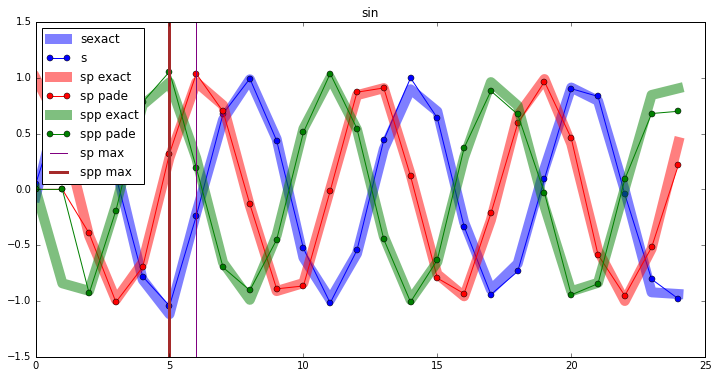

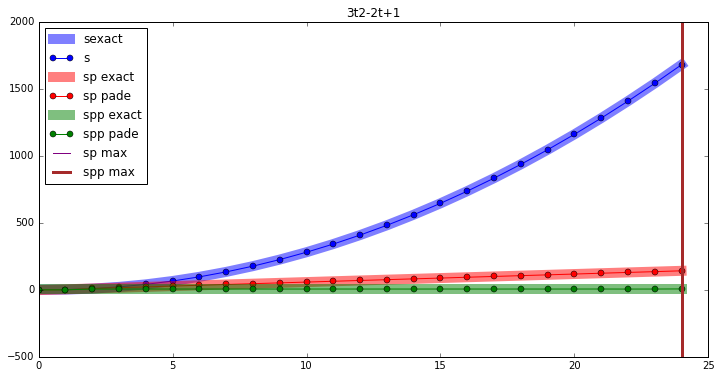

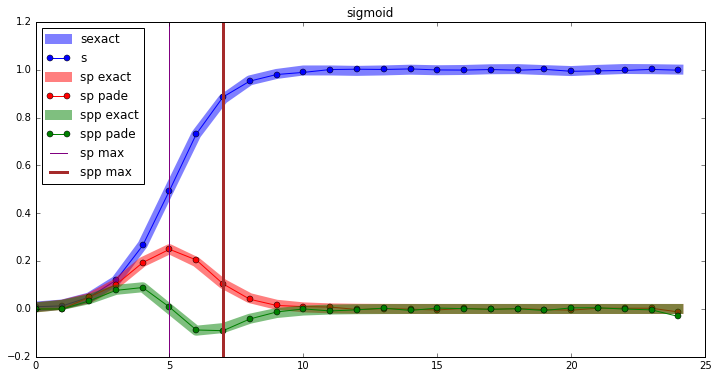

In [378]:
# C = X.iloc[0]
# Cp = Xp.iloc[0]
# Cpp = Xpp.iloc[0]

# f, fp, fpp = f1, f1p, f1pp

plot_derivs(t, 
            X.iloc[0][:,1], Xp.iloc[0][:,0], Xpp.iloc[0][:,0], 
            f1, f1p, f1pp, 
            triggerp.iloc[0][0], triggerpp.iloc[0][0],
            title='sin')
plot_derivs(t, 
            X.iloc[1][:,1], Xp.iloc[1][:,0], Xpp.iloc[1][:,0], 
            f2, f2p, f2pp, 
            triggerp.iloc[1][0], triggerpp.iloc[1][0],
            title='3t2-2t+1')
plot_derivs(t, 
            X.iloc[2][:,1], Xp.iloc[2][:,0], Xpp.iloc[2][:,0], 
            f3, f3p, f3pp, 
            triggerp.iloc[2][0], triggerpp.iloc[2][0],
            title='sigmoid')
# plot_derivs(t, X.iloc[1][:,1], Xp.iloc[1][:,0], Xpp.iloc[1][:,0], f2, f2p, f2pp, title='3t2-2t+1')
# plot_derivs(t, X.iloc[2][:,1], Xp.iloc[2][:,0], Xpp.iloc[2][:,0], f3, f3p, f3pp, title='sigmoid')

   ## Look at some actual trial data

In [339]:
import pickle
with open('pickles/DI.pkl', 'rb') as f:
    DI = pickle.load(f)

DI = DI.iloc[0:10]    
DI.iloc[0][0:15,:3]

array([[   0.,    0.,    0.],
       [  20.,    0.,    0.],
       [  40.,    0.,    0.],
       [  60.,    0.,    0.],
       [  80.,    0.,    0.],
       [ 100.,    0.,    0.],
       [ 120.,    0.,    0.],
       [ 140.,    0.,    0.],
       [ 160.,    0.,    0.],
       [ 180.,    0.,    0.],
       [ 200.,    4.,    6.],
       [ 220.,  -12.,   -6.],
       [ 240.,  -27.,   -3.],
       [ 260.,  -35.,  -11.],
       [ 280.,  -43.,  -10.]])

In [364]:
d1 = DerivativeFeaturizer(order=1, dx=20.0, reference_time=9, maxmin=False, verbose=True, gauss=False)
DIp, tpmax = d1.fit_transform(DI)

Taking derivatives of trial 0
Regressed 10 trials in 1 seconds


In [365]:
d2 = DerivativeFeaturizer(order=2, dx=20.0, reference_time=9, maxmin=False, verbose=True)
DIpp, tppmax = d2.fit_transform(DI)

Taking derivatives of trial 0
Regressed 10 trials in 3 seconds


In [366]:
d3 = DerivativeFeaturizer(order=2, dx=20.0, reference_time=9, maxmin=False, verbose=True, gauss=True, sigma=3)
Spp, Stppmax = d3.fit_transform(DI)
d4 = DerivativeFeaturizer(order=1, dx=20.0, reference_time=9, maxmin=False, verbose=True, gauss=True, sigma=3)
Sp, Stpmax = d4.fit_transform(DI)

stacked = DerivativeFeaturizer(order=2, dx=20.0, reference_time=9, maxmin=True, verbose=True, gauss=True, stacked=True)
DISmax, tsmax = stacked.fit_transform(DI)
stacked2 = DerivativeFeaturizer(order=2, dx=20.0, reference_time=9, maxmin=True, verbose=True, gauss=False, stacked=True)
DImax, tmax= stacked2.fit_transform(DI)



Taking derivatives of trial 0
Regressed 10 trials in 4 seconds
Taking derivatives of trial 0
Regressed 10 trials in 2 seconds
Taking derivatives of trial 0
Regressed 10 trials in 4 seconds
Taking derivatives of trial 0
Regressed 10 trials in 4 seconds


In [369]:
for spot in [66, 25, 123, 96, 76, 27]:
    plot_data2(DI, DIp, Sp, tpmax, Stpmax, index=0, spot=spot)

IndexError: index 65 is out of bounds for axis 1 with size 2

In [367]:
def plot_data2(X, Xp, Xps, tpmax, tppmax, index=0, spot=25):
    t = X.iloc[index][:,0]
    y = X.iloc[index][:,spot]
    yp = Xp.iloc[index][:,spot-1]
    ypp = Xpp.iloc[index][:,spot-1]

    tp = tpmax.iloc[index][spot-1]
    tpp = tppmax.iloc[index][spot-1]
    fig, ax1 = plt.subplots(figsize=(12,6))
#     plt.figure(figsize=(12,6))
#     plt.plot(t,x2,'b', linewidth=10, alpha=0.5, label='sexact')
    ax1.plot(t,y, 'b', label='y', linewidth=3, alpha=0.75)
    ax1.set_xlabel('t (min)')
    ax1.set_ylabel('DI')
#     plt.plot(t,y2, 'r', linewidth=10, alpha=0.5, label='sp exact')
  
    ax2 = ax1.twinx()
    ax2.plot(t,yp, 'ro-', label='yp')
#     plt.plot(t,z2, 'g', linewidth=10, alpha=0.5, label='spp exact')
    ax2.plot(t,ypp, 'go-', label='yps', linewidth=5, alpha=0.5)
    ax2.axvline(tp, color='r', label='sp max')
    ax2.axvline(tpp, color= 'g', label='sp max smoothed', linewidth=5, alpha=0.5)
    ax2.set_ylabel('yp and ypp')
    ax2.legend(loc=0)
    plt.title(str(index) + '-' + str(spot))

In [357]:
print Spp.iloc[0].shape, Stppmax.iloc[0].shape
print DISmax.head()
print DISmax.iloc[0].shape
print tsmax.head()
print tsmax.iloc[0].shape
print DImax.head()
print DImax.iloc[0].shape
print tmax.head()
print tmax.iloc[0].shape

(60, 219) (219,)
0    [[1.28237154839, 0.966533464374, 2.11091769911...
1    [[0.917669062522, 1.07902098034, 2.12664217101...
2    [[0.923315898042, 0.471621964609, 0.8830319189...
3    [[0.757931171281, 0.933697547823, 0.5636102081...
4    [[0.663588139001, 0.497384461393, 0.6366449079...
Name: data, dtype: object
(2, 219)
0    [[340.0, 860.0, 1180.0, 440.0, 420.0, 1180.0, ...
1    [[1180.0, 1180.0, 1180.0, 1180.0, 320.0, 640.0...
2    [[1180.0, 260.0, 420.0, 680.0, 520.0, 1180.0, ...
3    [[400.0, 360.0, 1180.0, 660.0, 320.0, 500.0, 5...
4    [[520.0, 220.0, 1180.0, 1180.0, 1180.0, 1040.0...
Name: data, dtype: object
(2, 219)
0    [[1.28237154839, 0.966533464374, 2.11091769911...
1    [[0.917669062522, 1.07902098034, 2.12664217101...
2    [[0.923315898042, 0.471621964609, 0.8830319189...
3    [[0.757931171281, 0.933697547823, 0.5636102081...
4    [[0.663588139001, 0.497384461393, 0.6366449079...
Name: data, dtype: object
(2, 219)
0    [[340.0, 860.0, 1180.0, 440.0, 420.0, 1180.0, ..

In [358]:
from scipy.ndimage.filters import gaussian_filter1d

def plot_data(X, Xp, Xpp, tpmax, tppmax, index=0, spot=25, gauss=False, sigma=2):
    t = X.iloc[index][:,0]
    y = X.iloc[index][:,spot]
    yp = Xp.iloc[index][:,spot-1]
    ypp = Xpp.iloc[index][:,spot-1]

    tp = tpmax.iloc[index][spot-1]
    tpp = tppmax.iloc[index][spot-1]
    fig, ax1 = plt.subplots(figsize=(12,6))
#     plt.figure(figsize=(12,6))
#     plt.plot(t,x2,'b', linewidth=10, alpha=0.5, label='sexact')
    ax1.plot(t,y, 'b', label='y', linewidth=3, alpha=0.75)
    ax1.set_xlabel('t (min)')
    ax1.set_ylabel('DI')
#     plt.plot(t,y2, 'r', linewidth=10, alpha=0.5, label='sp exact')
  
    ax2 = ax1.twinx()
    ax2.plot(t,yp, 'ro-', label='yp pade')
#     plt.plot(t,z2, 'g', linewidth=10, alpha=0.5, label='spp exact')
    ax2.plot(t,ypp, 'go-', label='ypp pade')
    ax2.axvline(tp, color='r', label='sp max')
    ax2.axvline(tpp, color= 'g', label='spp max')
    if gauss:
        yp = gaussian_filter1d(yp, sigma)
        ax2.plot(t,yp, 'r', linewidth=3, alpha=0.5)
        ypp = gaussian_filter1d(ypp,sigma)
        ax2.plot(t,ypp, 'g', linewidth=3, alpha=0.5)
        tp = np.argmax(np.abs(yp))*20
        tpp = np.argmax(np.abs(ypp))*20
        ax2.axvline(tp, color='r', linewidth=3, alpha=0.5)
        ax2.axvline(tpp, color= 'g', linewidth=3, alpha=0.5)
    ax2.set_ylabel('yp and ypp')
    ax2.legend(loc=0)
    plt.title(str(index) + '-' + str(spot))

In [370]:
for spot in [66, 25, 123, 96, 76, 27]:
    plot_data2(DI, Sp, Spp, Stpmax, Stppmax, index=0, spot=spot)

IndexError: index 65 is out of bounds for axis 1 with size 2

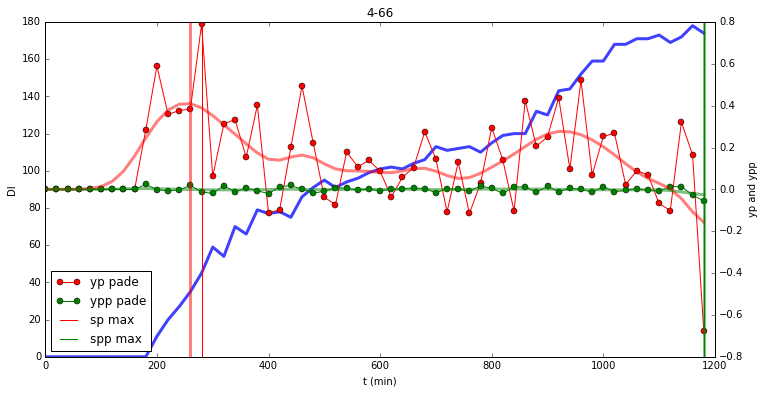

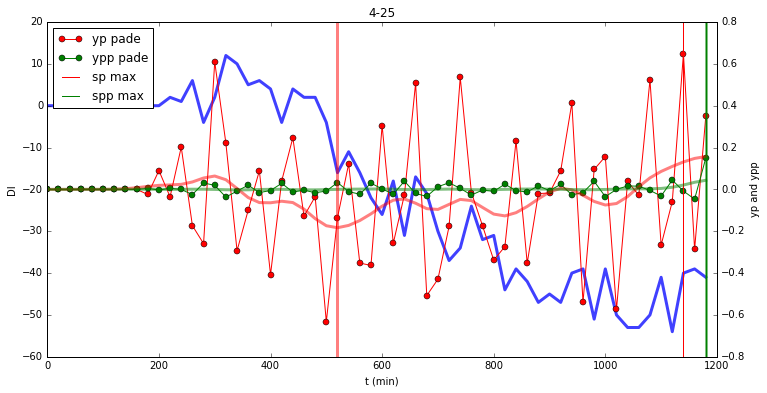

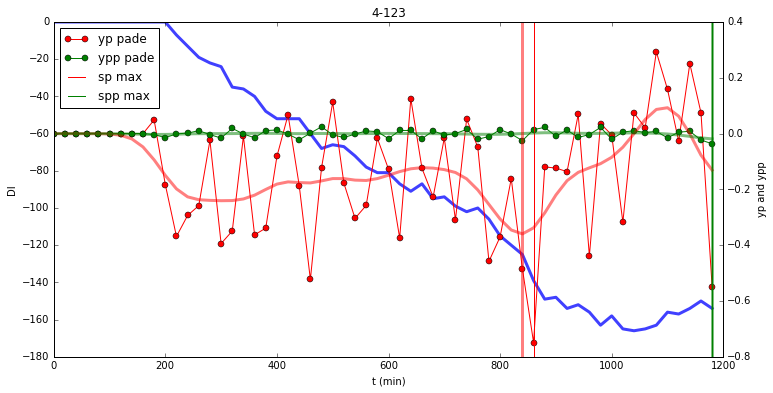

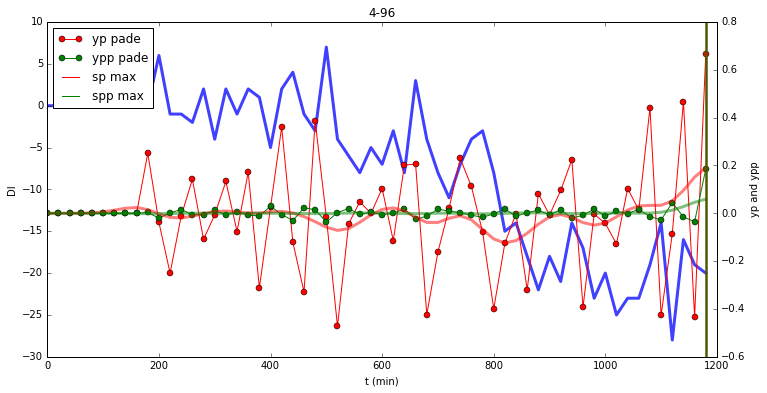

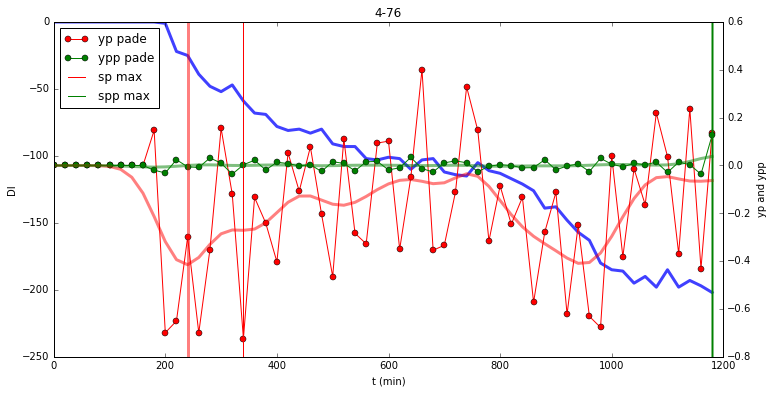

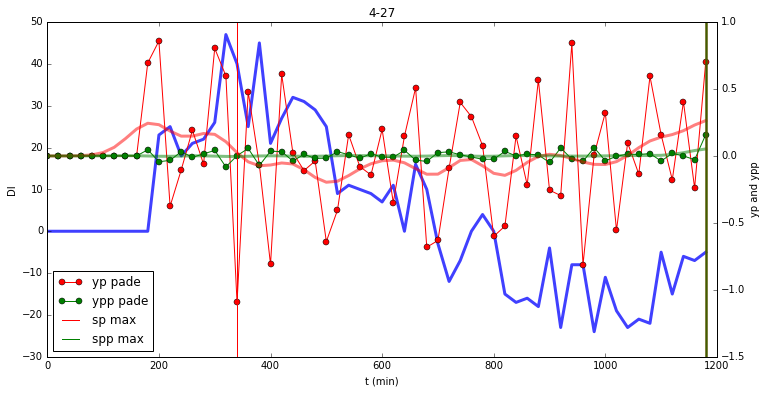

In [363]:
for spot in [66, 25, 123, 96, 76, 27]:
    plot_data(DI, DIp, DIpp, tpmax, tppmax, index=4, spot=spot, gauss=True)

# now for DII


In [295]:
import pickle
with open('output/DI.pkl', 'rb') as f:
    DII = pickle.load(f)

DII = DII.iloc[0:10]

from seriesmodel import SeriesModel
sm = SeriesModel()
DII = sm._subset_data(DII, 60)
DII.iloc[0][0:15,:3]

array([[   0.        ,    0.        ,    0.        ],
       [  20.        ,    0.        ,    0.        ],
       [  40.        ,    0.        ,    0.        ],
       [  60.        ,    0.        ,    0.        ],
       [  80.        ,    0.        ,    0.        ],
       [ 100.        ,    0.        ,    0.        ],
       [ 120.        ,    0.        ,    0.        ],
       [ 140.        ,    0.        ,    0.        ],
       [ 160.        ,    0.        ,    0.        ],
       [ 180.        ,    0.        ,    0.        ],
       [ 200.        ,    0.        ,    0.        ],
       [ 220.        ,    0.        ,    0.        ],
       [ 240.        ,    0.        ,    0.        ],
       [ 260.        ,   -0.44101433,   -0.42735043],
       [ 280.        ,   -0.88202867,   -0.37393162]])

In [296]:
DIIp, ttpmax = d1.fit_transform(DII)

Taking derivatives of trial 0
Regressed 10 trials in 1 seconds


In [297]:
DIIpp, ttppmax = d2.fit_transform(DI)

Taking derivatives of trial 0
Regressed 10 trials in 3 seconds


In [298]:
print DII.iloc[4].shape, DIIp.iloc[4].shape, DIIpp.iloc[4].shape

(60, 220) (60, 219) (60, 219)


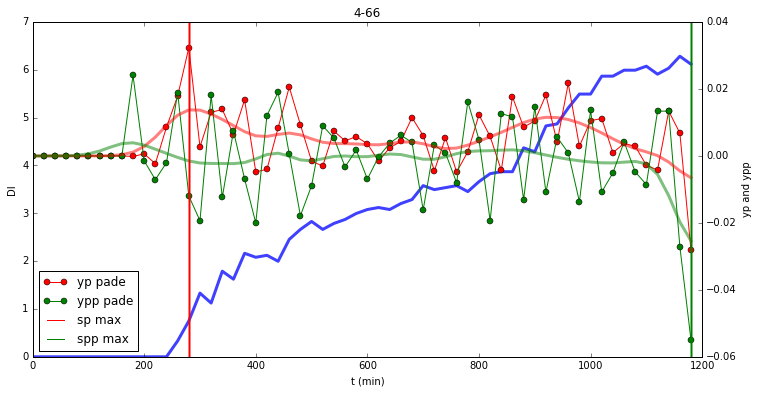

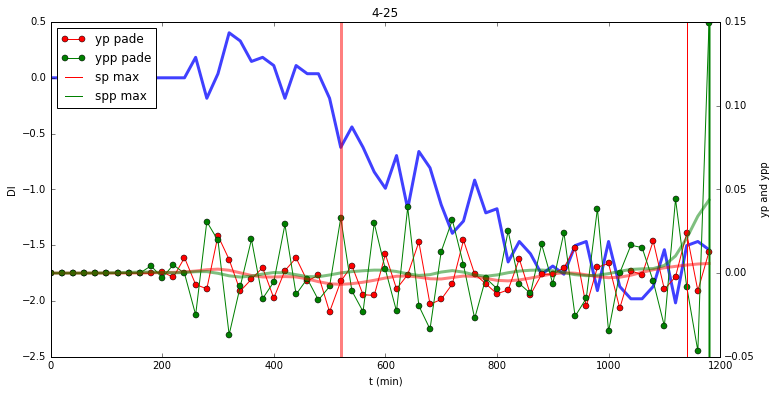

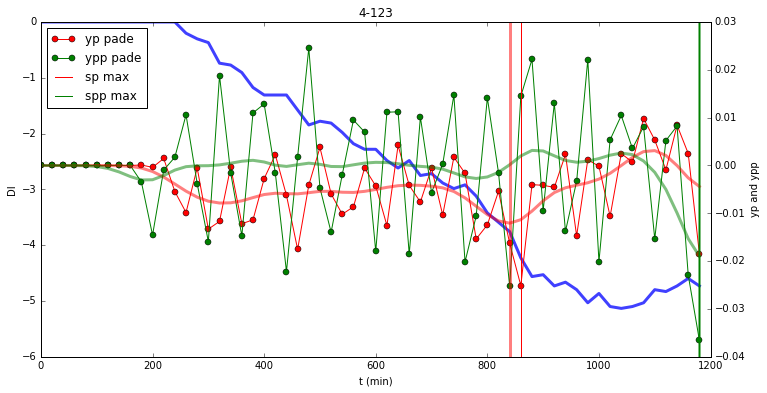

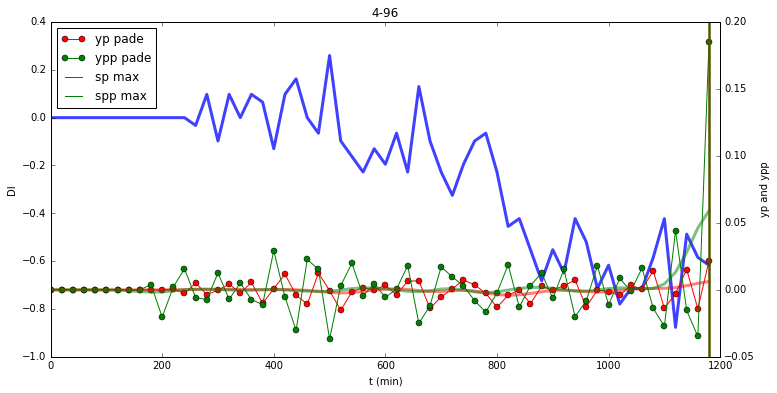

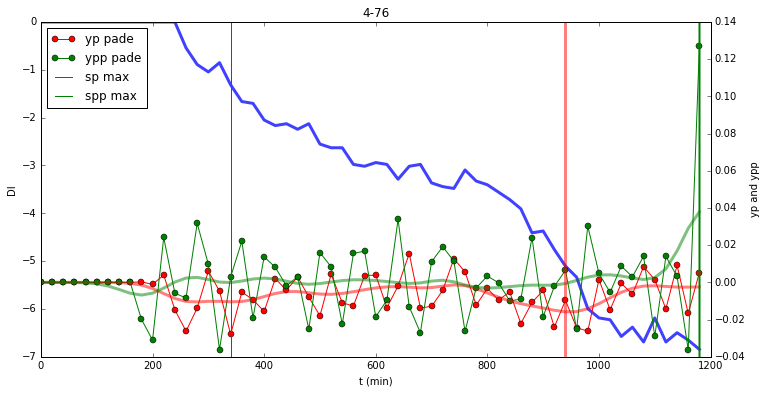

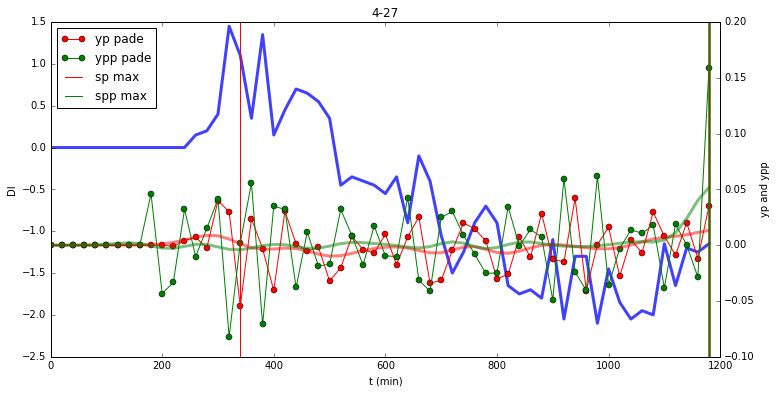

In [300]:
for spot in [66, 25, 123, 96, 76, 27]:
    plot_data(DII, DIIp, DIIpp, ttpmax, ttppmax, index=4, spot=spot, gauss=True)
    


In [ ]:
fig, ax1 = plt.subplots()
t = np.arange(0.01, 10.0, 0.01)
s1 = np.exp(t)
ax1.plot(t, s1, 'b-')
ax1.set_xlabel('time (s)')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('exp', color='b')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
s2 = np.sin(2*np.pi*t)
ax2.plot(t, s2, 'r.')
ax2.set_ylabel('sin', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.show()

plt.subplots?